In [1]:
# MODEL = "meta-llama/Llama-2-7b-hf"
MODEL = "meta-llama/Meta-Llama-3.1-8B"

In [4]:
import tqdm
import pandas as pd 
import wandb
import functools


@functools.cache
def get_df_from_wandb(path):
    api = wandb.Api()

    # Project is specified by <entity/project-name>
    runs = api.runs(path)
    
    data_df_lines = []
    for run in tqdm.tqdm(runs): 
        data_df_lines.append({
            'Name': run.name,
            'Commit': run.commit,
            **run.summary._json_dict,
            **{k: v for k,v in run.config.items() if not k.startswith('_')},
        })
    data_df = pd.DataFrame(data_df_lines)
    return data_df

In [5]:
data_df = get_df_from_wandb('rock-and-roll/NOISY_MSE_ONE_LINEAR_LAYER_GALQIWI_PPL')
data_df['layer'] = data_df['layer_name']
data_df['mse'] = data_df['relative_mse']
data_df = data_df[['layer', 'mse', 'wikitext2']]
data_df = data_df.dropna().copy()

34504it [04:58, 115.58it/s]                                                     


In [6]:
layers = sorted(set(data_df['layer']))
len(layers)

224

In [57]:
from scipy.stats import linregress


scale_by_layer = {}

for layer_idx, layer in enumerate(layers):
    to_fit = data_df[data_df['layer'] == layer]
    # to_fit = to_fit[to_fit['mse'] < 4 ** -1.7]
    to_fit = to_fit[to_fit['wikitext2'] < 5.640]
    
    scale_by_layer[layer] = linregress(to_fit['mse'], to_fit['wikitext2']).slope

In [55]:
scale_by_layer_old = scale_by_layer

(array([35., 34., 24., 23., 16., 38., 27.,  7.,  9.,  6.]),
 array([0.00307754, 0.0519854 , 0.10089325, 0.14980111, 0.19870897,
        0.24761683, 0.29652468, 0.34543254, 0.3943404 , 0.44324826,
        0.49215612]),
 <BarContainer object of 10 artists>)

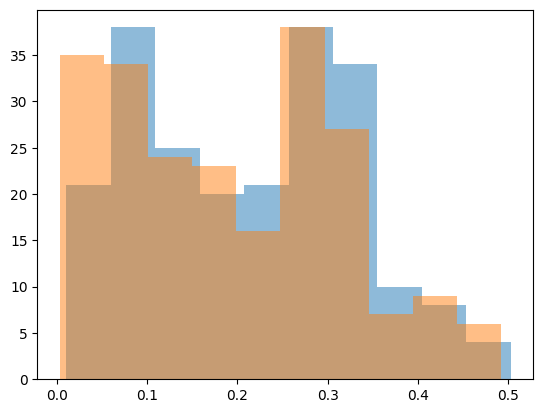

In [58]:
plt.hist(sorted((value for value in scale_by_layer_old.values() if value < 0.6)), bins=10, alpha=0.5)
plt.hist(sorted((value for value in scale_by_layer.values() if value < 0.6)), bins=10, alpha=0.5)

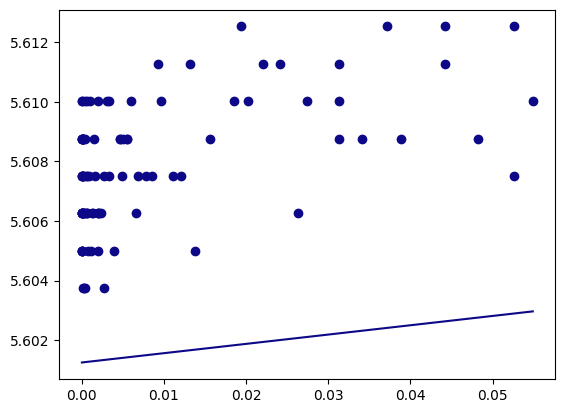

In [71]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


cmap = matplotlib.colormaps["plasma"]

for layer_idx, layer in enumerate({'model.layers.26.self_attn.k_proj'}):
    to_plot = data_df[data_df['layer'] == layer]
    to_plot = to_plot[to_plot['mse'] < 4 ** -2]
    to_plot = to_plot[to_plot['wikitext2'] < 5.640]
    
    plt.scatter(to_plot['mse'], to_plot['wikitext2'], color=cmap(layer_idx / len(layers)))

    grid = np.linspace(to_plot['mse'].min(), to_plot['mse'].max(), 10)
    
    plt.plot(grid, data_df['wikitext2'].min() + grid * scale_by_layer[layer], color=cmap(layer_idx / len(layers)))

In [59]:
pd.DataFrame(scale_by_layer.items(), columns=['layer', 'scale']).sort_values('scale')

,layer,scale
5,model.layers.0.self_attn.q_proj,0.003078
3,model.layers.0.self_attn.k_proj,0.009613
115,model.layers.23.self_attn.k_proj,0.030481
108,model.layers.22.self_attn.k_proj,0.031087
136,model.layers.26.self_attn.k_proj,0.031214
...,...,...
6,model.layers.0.self_attn.v_proj,0.952292
13,model.layers.1.self_attn.v_proj,1.090792
177,model.layers.31.mlp.up_proj,1.480820
175,model.layers.31.mlp.down_proj,2.976877


(array([ 6., 40., 31., 21., 26., 28., 36., 17.,  7.,  7.]),
 array([-0.00723147,  0.04625384,  0.09973916,  0.15322447,  0.20670979,
         0.2601951 ,  0.31368042,  0.36716574,  0.42065105,  0.47413637,
         0.52762168]),
 <BarContainer object of 10 artists>)

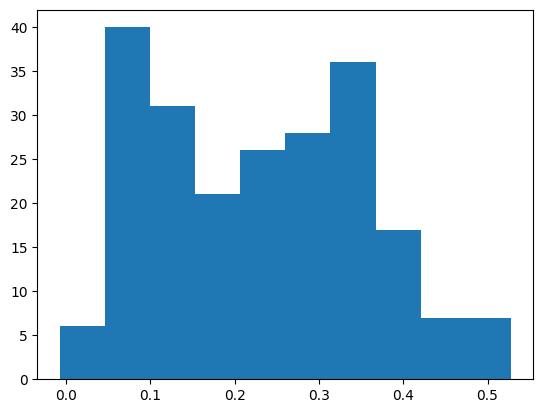

In [48]:
plt.hist(sorted((value for value in scale_by_layer.values() if value < 0.6)), bins=10)